In [55]:
import os
import pandas
import PIL.Image
import PIL.ImageDraw
import torch
import pandas
import xml.etree.ElementTree
import plotnine
import numpy
import tqdm

In [56]:
class dataset:
    
    def __init__(self, annotation=None, image=None):
        
        self.annotation = annotation
        self.image = image
        return

    def get(self, index=0):

        group = {
            'annotation':[a.split('.xml')[0] for a in os.listdir(self.annotation)],
            'image':[i.split('.jpg')[0] for i in os.listdir(self.image)]
        }
        group['set'] = set(group['annotation'] + group['image'])
        group['list'] = sorted(list(group['set']))
        item = group['list'][index]
        path = {
            "annotation":os.path.join(self.annotation, '{}.xml'.format(item)),
            'image':os.path.join(self.image, '{}.jpg'.format(item))
        }
        element = {}
        element['tree'] = xml.etree.ElementTree.parse(path['annotation'])
        element['root'] = element['tree'].getroot()
        element['object'] = element['root'].findall('object')
        element['box'] = [o.find('bndbox') for o in element['object']]
        parse = lambda box: [int(box.find(i).text) for i in ['xmin', 'ymin', 'xmax', 'ymax']]
        element['coordinate'] = [parse(box) for box in element['box']]
        picture = {}
        picture['image'] = PIL.Image.open(path['image'])
        picture['size'] = picture['image'].size
        return(item, picture, element)
    
    def display(self, index=0, show=True, size=None):

        _, picture, element = self.get(index=index)
        paper = PIL.ImageDraw.Draw(picture['image'])
        for c in element['coordinate']:
            
            region = (c[0], c[1]), (c[2], c[3])
            paper.rectangle(region, outline='red', width=5)
            continue

        image = picture['image']
        if(size): image = image.resize(size)
        if(show): image.show()
        return(image)

    pass

In [57]:
dataset = dataset(annotation='../resource/ACNE04/Detection/VOC2007/Annotations/', image='../resource/ACNE04/Classification/JPEGImages/')

In [58]:
dataset.get(index=1)

('levle0_1',
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3112x3456 at 0x7F48C24E40D0>,
  'size': (3112, 3456)},
 {'tree': <xml.etree.ElementTree.ElementTree at 0x7f48c24178e0>,
  'root': <Element 'annotation' at 0x7f48c2b50450>,
  'object': [<Element 'object' at 0x7f48c2c2fb80>,
   <Element 'object' at 0x7f48c2b4ad60>,
   <Element 'object' at 0x7f48c2b4a090>],
  'box': [<Element 'bndbox' at 0x7f48c2b4af90>,
   <Element 'bndbox' at 0x7f48c2b4a630>,
   <Element 'bndbox' at 0x7f48c2b4ac20>],
  'coordinate': [[394, 933, 493, 1064],
   [654, 2160, 754, 2274],
   [930, 3079, 1099, 3179]]})

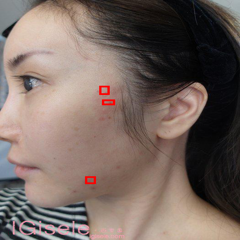

In [59]:
dataset.display(index=0, show=False, size=(240, 240))

In [60]:
collection = {
    'item':[], 'index':[], 'level':[], 
    'scale(min)':[], 'scale(median)':[], 
    'scale(mean)':[], 'scale(max)':[], 'scale(std)':[]
}
number = 1457
loop = range(number)
for i in tqdm.tqdm(loop, total=number):

    item, picture, element = dataset.get(index=i)
    level = item.split('_')[0][-1]
    image, _, _ = picture['image'].split()
    for index, coordinate in enumerate(element['coordinate']):
        
        compute = lambda image, box: numpy.array(image.crop(box))
        scale = compute(image=image.copy(), box=coordinate).astype('float')
        collection['item']  += [item]
        collection['index'] += [index]
        collection['level'] += [level]
        collection['scale(min)']     += [numpy.min(scale)]
        collection['scale(median)']  += [numpy.median(scale)]
        collection['scale(mean)']    += [numpy.mean(scale)]
        collection['scale(max)']     += [numpy.max(scale)]
        collection['scale(std)']     += [numpy.std(scale)]
        continue

    continue

collection = pandas.DataFrame(collection)

100%|██████████| 1457/1457 [06:33<00:00,  3.70it/s]


In [61]:
sheet = {}

In [62]:
sheet['single acne scale'] = collection.copy()
sheet['single acne scale'].head()

,item,index,level,scale(min),scale(median),scale(mean),scale(max),scale(std)
0,levle0_0,0,0,130.0,161.0,159.147321,177.0,8.914810
1,levle0_0,1,0,155.0,180.0,179.256993,201.0,7.603507
2,levle0_0,2,0,121.0,133.0,134.005929,147.0,4.857451
3,levle0_1,0,0,24.0,157.0,153.127226,193.0,17.174933
4,levle0_1,1,0,152.0,174.0,174.465088,219.0,5.566158


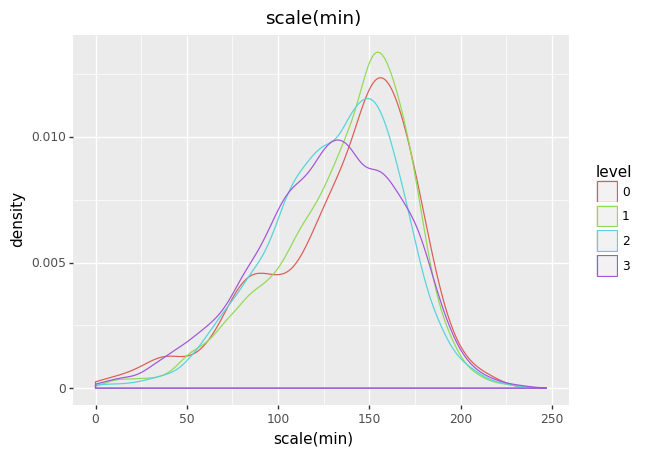

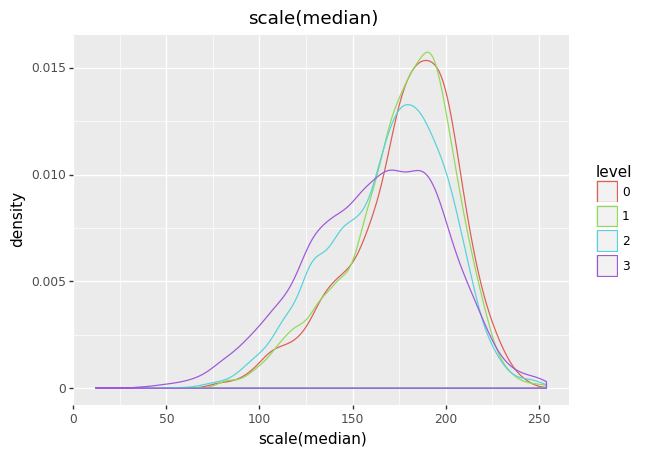

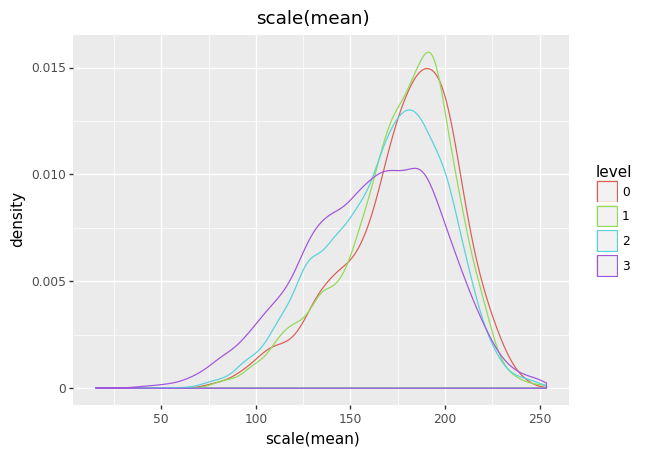

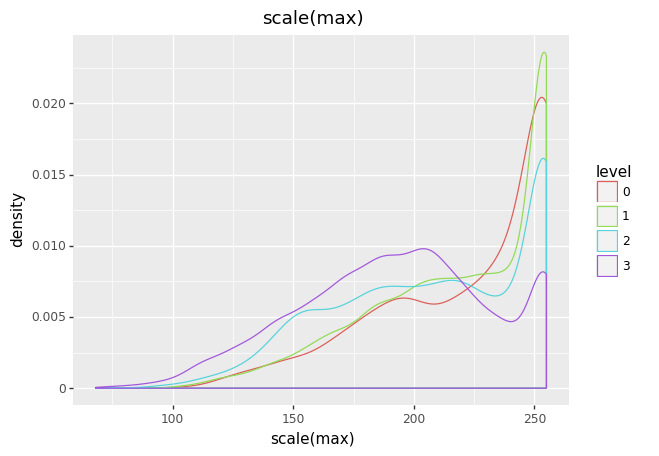

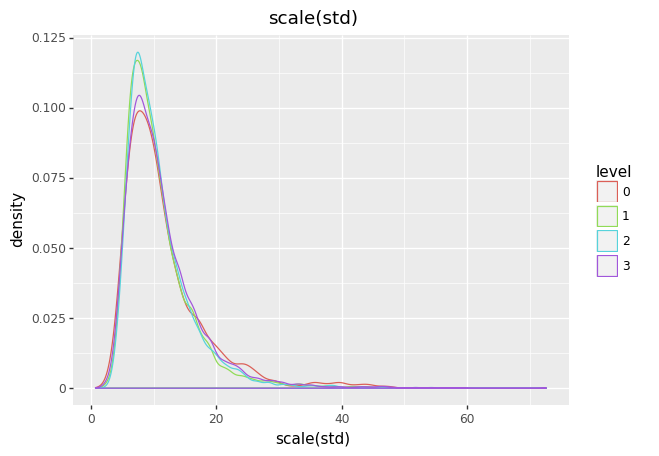

In [64]:
data = sheet['single acne scale'].copy()
graph = {1:None, 2:None, 3:None, 4:None, 5:None}
graph[1] = plotnine.ggplot(data) + plotnine.aes(x='scale(min)',color='level') + plotnine.geom_density() + plotnine.labels.ggtitle('scale(min)')
graph[2] = plotnine.ggplot(data) + plotnine.aes(x='scale(median)',color='level') + plotnine.geom_density() + plotnine.labels.ggtitle('scale(median)')
graph[3] = plotnine.ggplot(data) + plotnine.aes(x='scale(mean)',color='level') + plotnine.geom_density() + plotnine.labels.ggtitle('scale(mean)')
graph[4] = plotnine.ggplot(data) + plotnine.aes(x='scale(max)',color='level') + plotnine.geom_density() + plotnine.labels.ggtitle('scale(max)')
graph[5] = plotnine.ggplot(data) + plotnine.aes(x='scale(std)',color='level') + plotnine.geom_density() + plotnine.labels.ggtitle('scale(std)')
print(graph[1])
print(graph[2])
print(graph[3])
print(graph[4])
print(graph[5])

In [65]:
print('scale(min)')
sheet['level acne scale(min) with single'] = data.groupby(['level'])['scale(min)'].describe().reset_index().copy()
sheet['level acne scale(min) with single'].head()

scale(min)


,level,count,mean,std,min,25%,50%,75%,max
0,0,1043.0,134.129434,40.676425,0.0,111.0,144.0,163.0,220.0
1,1,5548.0,135.881218,36.783211,4.0,114.0,143.0,162.0,233.0
2,2,4663.0,130.472443,35.760183,0.0,107.0,134.0,156.0,235.0
3,3,7729.0,127.605512,40.060685,0.0,102.0,130.0,157.0,247.0


In [66]:
print('scale(median)')
sheet['level acne scale(median) with single'] = data.groupby(['level'])['scale(median)'].describe().reset_index().copy()
sheet['level acne scale(median) with single'].head()

scale(median)


,level,count,mean,std,min,25%,50%,75%,max
0,0,1043.0,177.397411,29.250737,78.0,161.0,182.0,198.0,242.0
1,1,5548.0,175.822368,29.130531,56.0,160.0,180.0,196.0,254.0
2,2,4663.0,169.183251,31.564834,58.0,147.0,173.0,192.0,254.0
3,3,7729.0,161.572843,36.894148,12.0,136.0,165.0,189.0,254.0


In [67]:
print('scale(mean)')
sheet['level acne scale(mean) with single'] = data.groupby(['level'])['scale(mean)'].describe().reset_index().copy()
sheet['level acne scale(mean) with single'].head()

scale(mean)


,level,count,mean,std,min,25%,50%,75%,max
0,0,1043.0,177.044529,30.056681,77.996054,159.220578,182.507826,198.382712,241.888991
1,1,5548.0,175.602141,29.493313,56.568830,158.918261,180.115945,196.257522,253.508984
2,2,4663.0,168.821130,31.741397,59.353985,146.912689,172.761275,192.077583,251.396013
3,3,7729.0,161.161488,36.730527,15.286458,135.882275,164.173160,188.400585,253.610984


In [68]:
print('scale(max)')
sheet['level acne scale(max) with single'] = data.groupby(['level'])['scale(max)'].describe().reset_index().copy()
sheet['level acne scale(max) with single'].head()

scale(max)


,level,count,mean,std,min,25%,50%,75%,max
0,0,1043.0,222.261745,35.456274,104.0,196.5,235.0,255.0,255.0
1,1,5548.0,219.281182,35.851258,76.0,195.0,228.0,255.0,255.0
2,2,4663.0,208.076989,39.938250,74.0,178.0,213.0,249.0,255.0
3,3,7729.0,192.852115,39.679314,68.0,165.0,195.0,222.0,255.0


In [69]:
print('scale(std)')
sheet['level acne scale(std) with single'] = data.groupby(['level'])['scale(std)'].describe().reset_index().copy()
sheet['level acne scale(std) with single'].head()

scale(std)


,level,count,mean,std,min,25%,50%,75%,max
0,0,1043.0,11.660586,6.716759,2.601342,7.234355,9.820388,13.750316,47.606854
1,1,5548.0,10.740721,5.505572,2.248922,7.119422,9.347007,12.695611,62.635131
2,2,4663.0,10.820810,5.301702,2.521899,7.291732,9.469776,12.819420,54.316535
3,3,7729.0,11.294754,6.069637,0.726184,7.343940,9.831348,13.519761,72.658858


In [70]:
sheet['item acne scale(min)'] = sheet['single acne scale'].groupby(['item','level'])[['scale(min)']].sum().reset_index().copy()
sheet['item acne scale(min)'].head()

,item,level,scale(min)
0,levle0_0,0,406.0
1,levle0_1,0,256.0
2,levle0_10,0,2933.0
3,levle0_100,0,271.0
4,levle0_101,0,124.0


In [71]:
sheet['item acne scale(median)'] = sheet['single acne scale'].groupby(['item','level'])[['scale(median)']].sum().reset_index().copy()
sheet['item acne scale(median)'].head()

,item,level,scale(median)
0,levle0_0,0,474.0
1,levle0_1,0,461.0
2,levle0_10,0,3263.0
3,levle0_100,0,340.0
4,levle0_101,0,173.0


In [72]:
sheet['item acne scale(mean)'] = sheet['single acne scale'].groupby(['item','level'])[['scale(mean)']].sum().reset_index().copy()
sheet['item acne scale(mean)'].head()

,item,level,scale(mean)
0,levle0_0,0,472.410243
1,levle0_1,0,454.020835
2,levle0_10,0,3254.063037
3,levle0_100,0,339.678376
4,levle0_101,0,172.432065


In [73]:
sheet['item acne scale(max)'] = sheet['single acne scale'].groupby(['item','level'])[['scale(max)']].sum().reset_index().copy()
sheet['item acne scale(max)'].head()

,item,level,scale(max)
0,levle0_0,0,525.0
1,levle0_1,0,562.0
2,levle0_10,0,3496.0
3,levle0_100,0,388.0
4,levle0_101,0,222.0


In [74]:
sheet['item acne scale(std)'] = sheet['single acne scale'].groupby(['item','level'])[['scale(std)']].sum().reset_index().copy()
sheet['item acne scale(std)'].head()

,item,level,scale(std)
0,levle0_0,0,21.375768
1,levle0_1,0,36.300539
2,levle0_10,0,111.435425
3,levle0_100,0,15.907417
4,levle0_101,0,11.521384


In [75]:
sheet['level acne scale(min) with item'] = sheet['item acne scale(min)'].groupby(['level'])['scale(min)'].describe().reset_index().copy()
sheet['level acne scale(min) with item'].head()

,level,count,mean,std,min,25%,50%,75%,max
0,0,497.0,281.482897,191.266482,6.0,161.00,254.0,350.0,2933.0
1,1,637.0,1183.467818,457.337218,49.0,889.00,1069.0,1379.0,3781.0
2,2,186.0,3270.930108,959.641780,1184.0,2676.75,3220.0,3661.5,7479.0
3,3,137.0,7199.000000,1908.013434,2698.0,5728.00,7251.0,8470.0,11618.0


In [63]:
##  Todo: Other scale class embedding.